# REINFORCE : Monte-Carlo Policy Gradient

![좋은거](https://leimao.github.io/images/article/2017-05-04-REINFORCE-Policy-Gradient/Sutton_REINFORCE.png)

In [1]:
%%time
## 약 25초 ~30초 소요
!pip install pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg
!pip install gym
!pip install box2d-py
#!pip install pyglet==1.3.2
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 13 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,686 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 1,280 kB in 2s (519 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 149406 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd64

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# CartPole-v1

In [5]:
env = wrap_env(gym.make("CartPole-v1"))
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state = env.reset()
for t in range(1000):
    action = env.action_space.sample() # your agent here (this takes random actions)
    env.render()
    observation, reward, done, info = env.step(action)
    if done: 
      break;
            
print('steps: ', t)
env.close()
show_video()

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
steps:  20


In [6]:
print("state 수는? : ", env.observation_space.shape)
print("action 수는? : ", env.action_space.n)

state 수는? :  (4,)
action 수는? :  2


In [7]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Add, Subtract, Average, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

# Policy Network

1. 히든레이어는 자유롭게 구성하시오.
    * 너무 과하거나 모자라면 엄청 오래걸림
2. policy(a|s)를 구현하면 됨
    * 인풋이 state
    * 아웃풋은 액션별 확률 ('softmax')

In [8]:
keras.backend.clear_session()
######################
### Your Code Here ###
######################

state_layer = Input(shape=(4,))
hidden = Dense(128, activation='relu')(state_layer)
hidden = Dense(64, activation='relu')(hidden)
policy_layer = Dense(2, activation='softmax')(hidden)

policy_network = Model(state_layer, policy_layer)

policy_network.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(0.01))

policy_network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 9,026
Trainable params: 9,026
Non-trainable params: 0
_________________________________________________________________


# Policy를 1회 학습시켜보자.

### 1. policy network를 이용하여 한번의 episode를 기록한다.

In [9]:
state_history = []
action_history = []
reward_history = []

for i in range(1):
    env = wrap_env(gym.make("CartPole-v1"))
    s0 = env.reset()
    done = False

    cum_r = 0
    time_step = 0
    while True :
        time_step = time_step + 1

        s0 = s0.reshape([1, -1])
        policy = policy_network.predict(s0).reshape(-1)
        a0 = np.random.choice(env.action_space.n, p = policy) # env.action_space.n(0~1) 중에서 1개 선택하는데 policy 비율이 높은것을 골라라
        s1, r1, done, _ = env.step(a0)
        
        a0 = np.eye(env.action_space.n)[a0].reshape([1,-1])
        
        state_history.append(s0)
        action_history.append(a0)
        reward_history.append(r1)

        if time_step % 50 == 0 :
            print(" TimeStep : {} 진행중".format(time_step))

        if done == True :
            env.close()
            show_video()
            break
        s0 = s1

# 학습을 진행!

# Return Normalization!

In [10]:
gamma = 0.99  # Discount factor for past rewards
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
eps = np.finfo(np.float32).eps.item()  ## 매우 작은 수.

In [11]:
returns = []
Gt = 0
for r in reward_history[::-1] : # 거꾸로 뽑는다.
    Gt = r + gamma*Gt
    returns.insert(0,  Gt) # append를 0번 인덱스부터 하는 것!

In [12]:
# Normalize
returns = np.array(returns)
returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
returns = returns.reshape([-1,1])
returns.shape

(13, 1)

In [13]:
state = np.vstack(state_history)
state.shape

(13, 4)

In [14]:
action_dummy = np.vstack(action_history)
action_dummy.shape

(13, 2)

In [15]:
G_target = action_dummy*returns

In [16]:
policy_network.fit(state, G_target, verbose=0, epochs=1, batch_size=100000)

# Episode 1000회 학습을 시켜보자!

In [17]:
from collections import deque
memory = deque(maxlen=10)

--------0---------
--------1---------
--------2---------
--------3---------
--------4---------
--------5---------
--------6---------
--------7---------
--------8---------
--------9---------
--------10---------
--------11---------
--------12---------
--------13---------
--------14---------
--------15---------
--------16---------
--------17---------
--------18---------
--------19---------
20번째 episode 학습 완료
[1.0000000e+00 4.8678544e-22]


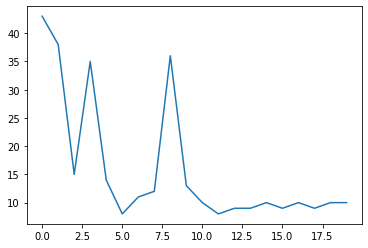

--------20---------
--------21---------
--------22---------
--------23---------
--------24---------
--------25---------
--------26---------
--------27---------
--------28---------
--------29---------
--------30---------
--------31---------
--------32---------
--------33---------
--------34---------
--------35---------
--------36---------
--------37---------
--------38---------
--------39---------
40번째 episode 학습 완료
[0. 1.]


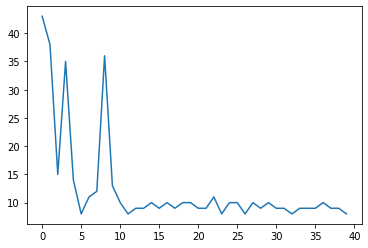

--------40---------
--------41---------
--------42---------
--------43---------
--------44---------
--------45---------
--------46---------
--------47---------
--------48---------
--------49---------
--------50---------
--------51---------
--------52---------
--------53---------
--------54---------
--------55---------
--------56---------
--------57---------
--------58---------
--------59---------
60번째 episode 학습 완료
[0. 1.]


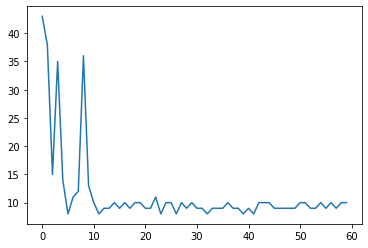

--------60---------
--------61---------
--------62---------
--------63---------
--------64---------
--------65---------
--------66---------
--------67---------
--------68---------
--------69---------
--------70---------
--------71---------
--------72---------
--------73---------
--------74---------
--------75---------
--------76---------
--------77---------
--------78---------
--------79---------
80번째 episode 학습 완료
[0. 1.]


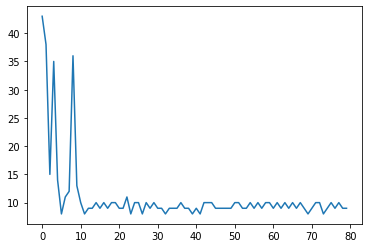

--------80---------
--------81---------
--------82---------
--------83---------
--------84---------
--------85---------
--------86---------
--------87---------
--------88---------
--------89---------
--------90---------
--------91---------
--------92---------
--------93---------
--------94---------
--------95---------
--------96---------
--------97---------
--------98---------
--------99---------
100번째 episode 학습 완료
[1. 0.]


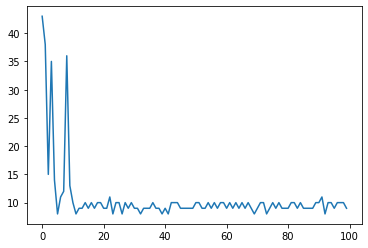

--------100---------
--------101---------
--------102---------
--------103---------
--------104---------
--------105---------
--------106---------
--------107---------
--------108---------
--------109---------
--------110---------
--------111---------
--------112---------
--------113---------
--------114---------
--------115---------
--------116---------
--------117---------
--------118---------
--------119---------
120번째 episode 학습 완료
[0. 1.]


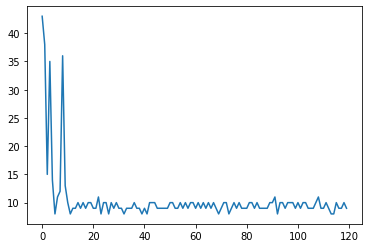

--------120---------
--------121---------
--------122---------
--------123---------
--------124---------
--------125---------
--------126---------
--------127---------
--------128---------
--------129---------
--------130---------
--------131---------
--------132---------
--------133---------
--------134---------
--------135---------
--------136---------
--------137---------
--------138---------
--------139---------
140번째 episode 학습 완료
[0. 1.]


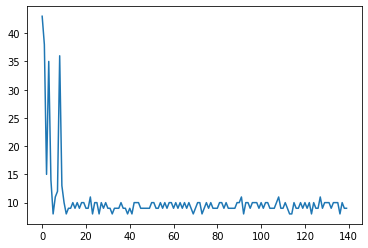

--------140---------
--------141---------
--------142---------
--------143---------
--------144---------
--------145---------
--------146---------
--------147---------
--------148---------
--------149---------
--------150---------
--------151---------
--------152---------
--------153---------
--------154---------
--------155---------
--------156---------
--------157---------
--------158---------
--------159---------
160번째 episode 학습 완료
[1. 0.]


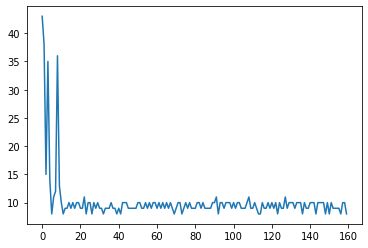

--------160---------
--------161---------
--------162---------
--------163---------
--------164---------
--------165---------
--------166---------
--------167---------
--------168---------
--------169---------
--------170---------
--------171---------
--------172---------
--------173---------
--------174---------
--------175---------
--------176---------
--------177---------
--------178---------
--------179---------
180번째 episode 학습 완료
[0. 1.]


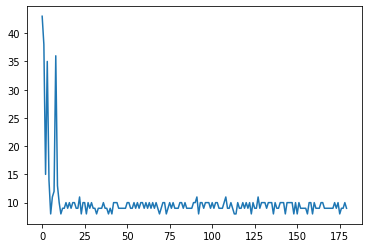

--------180---------
--------181---------
--------182---------
--------183---------
--------184---------
--------185---------
--------186---------
--------187---------
--------188---------
--------189---------
--------190---------
--------191---------
--------192---------
--------193---------
--------194---------
--------195---------
--------196---------
--------197---------
--------198---------
--------199---------
200번째 episode 학습 완료
[1. 0.]


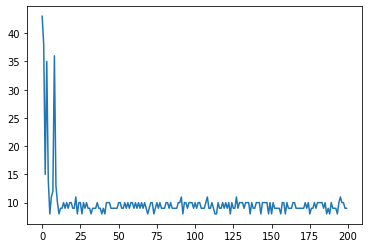

--------200---------
--------201---------
--------202---------
--------203---------
--------204---------
--------205---------
--------206---------
--------207---------
--------208---------
--------209---------
--------210---------
--------211---------
--------212---------
--------213---------
--------214---------
--------215---------
--------216---------
--------217---------
--------218---------
--------219---------
220번째 episode 학습 완료
[1. 0.]


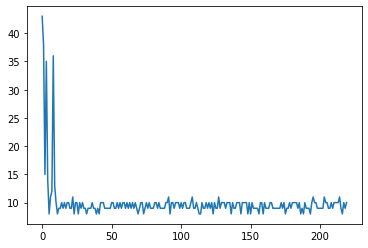

--------220---------
--------221---------
--------222---------
--------223---------
--------224---------
--------225---------
--------226---------
--------227---------
--------228---------
--------229---------
--------230---------
--------231---------
--------232---------
--------233---------
--------234---------
--------235---------
--------236---------
--------237---------
--------238---------
--------239---------
240번째 episode 학습 완료
[0. 1.]


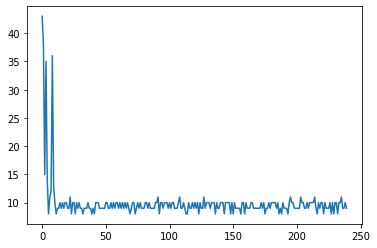

--------240---------
--------241---------
--------242---------
--------243---------
--------244---------
--------245---------
--------246---------
--------247---------
--------248---------
--------249---------
--------250---------
--------251---------
--------252---------
--------253---------
--------254---------
--------255---------
--------256---------
--------257---------
--------258---------
--------259---------
260번째 episode 학습 완료
[0. 1.]


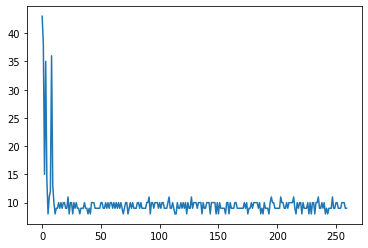

--------260---------
--------261---------
--------262---------
--------263---------
--------264---------
--------265---------
--------266---------
--------267---------
--------268---------
--------269---------
--------270---------
--------271---------
--------272---------
--------273---------
--------274---------
--------275---------
--------276---------
--------277---------
--------278---------
--------279---------
280번째 episode 학습 완료
[0. 1.]


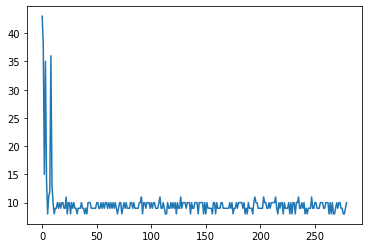

--------280---------
--------281---------
--------282---------
--------283---------
--------284---------
--------285---------
--------286---------
--------287---------
--------288---------
--------289---------
--------290---------
--------291---------
--------292---------
--------293---------
--------294---------
--------295---------
--------296---------
--------297---------
--------298---------
--------299---------
300번째 episode 학습 완료
[1. 0.]


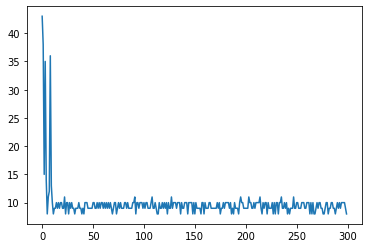

--------300---------
--------301---------
--------302---------
--------303---------
--------304---------
--------305---------
--------306---------
--------307---------
--------308---------
--------309---------
--------310---------
--------311---------
--------312---------
--------313---------
--------314---------
--------315---------
--------316---------
--------317---------
--------318---------
--------319---------
320번째 episode 학습 완료
[1. 0.]


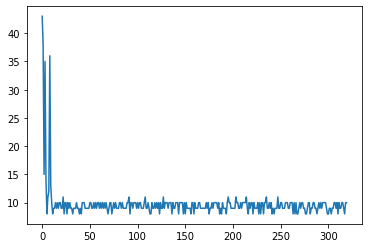

--------320---------
--------321---------
--------322---------
--------323---------
--------324---------
--------325---------
--------326---------
--------327---------
--------328---------
--------329---------
--------330---------
--------331---------
--------332---------
--------333---------
--------334---------
--------335---------
--------336---------
--------337---------
--------338---------
--------339---------
340번째 episode 학습 완료
[1. 0.]


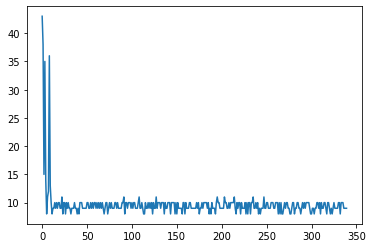

--------340---------
--------341---------
--------342---------
--------343---------
--------344---------
--------345---------
--------346---------
--------347---------
--------348---------
--------349---------
--------350---------
--------351---------
--------352---------
--------353---------
--------354---------
--------355---------
--------356---------
--------357---------
--------358---------
--------359---------
360번째 episode 학습 완료
[1. 0.]


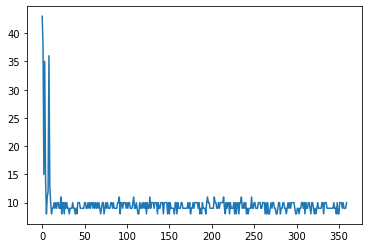

--------360---------
--------361---------
--------362---------
--------363---------
--------364---------
--------365---------
--------366---------
--------367---------
--------368---------
--------369---------
--------370---------
--------371---------
--------372---------
--------373---------
--------374---------
--------375---------
--------376---------
--------377---------
--------378---------
--------379---------
380번째 episode 학습 완료
[1. 0.]


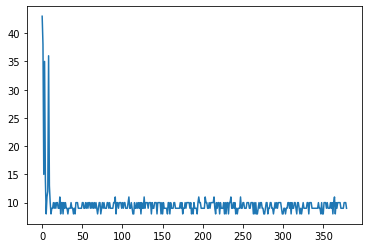

--------380---------
--------381---------
--------382---------
--------383---------
--------384---------
--------385---------
--------386---------
--------387---------
--------388---------
--------389---------
--------390---------
--------391---------
--------392---------
--------393---------
--------394---------
--------395---------
--------396---------
--------397---------
--------398---------
--------399---------
400번째 episode 학습 완료
[1. 0.]


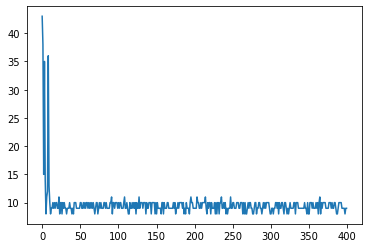

--------400---------
--------401---------
--------402---------
--------403---------
--------404---------
--------405---------
--------406---------
--------407---------
--------408---------
--------409---------
--------410---------
--------411---------
--------412---------
--------413---------
--------414---------
--------415---------
--------416---------
--------417---------
--------418---------
--------419---------
420번째 episode 학습 완료
[1. 0.]


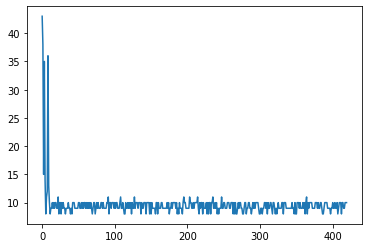

--------420---------
--------421---------
--------422---------
--------423---------
--------424---------
--------425---------
--------426---------
--------427---------
--------428---------
--------429---------
--------430---------
--------431---------
--------432---------
--------433---------
--------434---------
--------435---------
--------436---------
--------437---------
--------438---------
--------439---------
440번째 episode 학습 완료
[0. 1.]


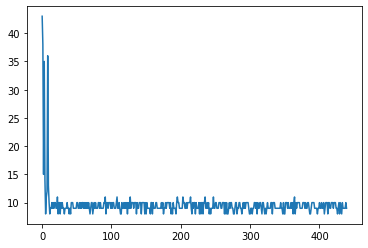

--------440---------
--------441---------
--------442---------
--------443---------
--------444---------
--------445---------
--------446---------
--------447---------
--------448---------
--------449---------
--------450---------
--------451---------
--------452---------
--------453---------
--------454---------
--------455---------
--------456---------
--------457---------
--------458---------
--------459---------
460번째 episode 학습 완료
[1. 0.]


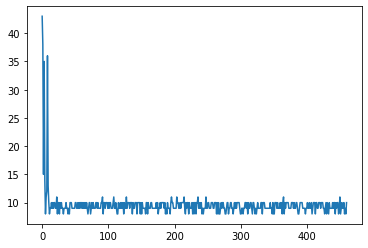

--------460---------
--------461---------
--------462---------
--------463---------
--------464---------
--------465---------
--------466---------
--------467---------
--------468---------
--------469---------
--------470---------
--------471---------
--------472---------
--------473---------
--------474---------
--------475---------
--------476---------
--------477---------
--------478---------
--------479---------
480번째 episode 학습 완료
[1. 0.]


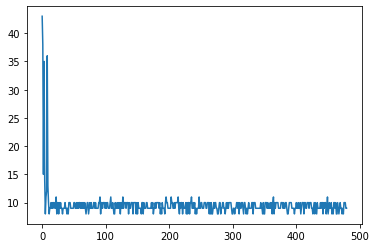

--------480---------
--------481---------
--------482---------
--------483---------
--------484---------
--------485---------
--------486---------
--------487---------
--------488---------
--------489---------
--------490---------
--------491---------
--------492---------
--------493---------
--------494---------
--------495---------
--------496---------
--------497---------
--------498---------
--------499---------
500번째 episode 학습 완료
[0. 1.]


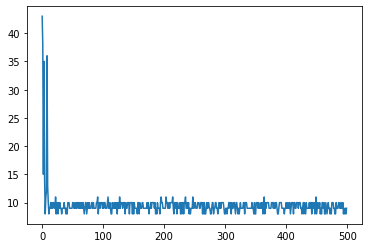

--------500---------
--------501---------
--------502---------
--------503---------
--------504---------
--------505---------
--------506---------
--------507---------
--------508---------
--------509---------
--------510---------
--------511---------
--------512---------
--------513---------
--------514---------
--------515---------
--------516---------
--------517---------
--------518---------
--------519---------
520번째 episode 학습 완료
[1. 0.]


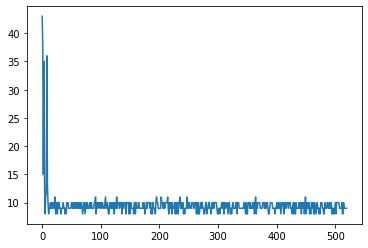

--------520---------
--------521---------
--------522---------
--------523---------
--------524---------
--------525---------
--------526---------
--------527---------
--------528---------
--------529---------
--------530---------
--------531---------
--------532---------
--------533---------
--------534---------
--------535---------
--------536---------
--------537---------
--------538---------
--------539---------
540번째 episode 학습 완료
[1. 0.]


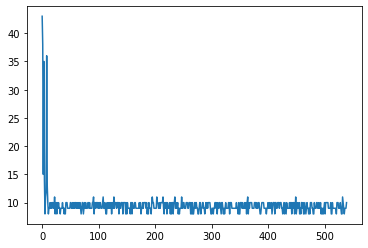

--------540---------
--------541---------
--------542---------
--------543---------
--------544---------
--------545---------
--------546---------
--------547---------
--------548---------
--------549---------
--------550---------
--------551---------
--------552---------
--------553---------
--------554---------
--------555---------
--------556---------
--------557---------
--------558---------
--------559---------
560번째 episode 학습 완료
[0. 1.]


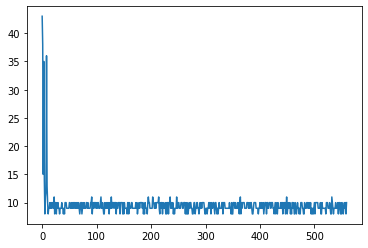

--------560---------
--------561---------
--------562---------
--------563---------
--------564---------
--------565---------
--------566---------
--------567---------
--------568---------
--------569---------
--------570---------
--------571---------
--------572---------
--------573---------
--------574---------
--------575---------
--------576---------
--------577---------
--------578---------
--------579---------
580번째 episode 학습 완료
[1. 0.]


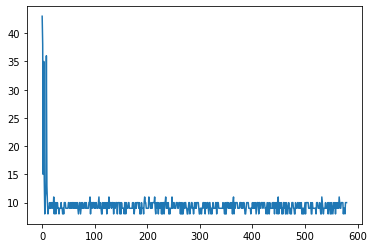

--------580---------
--------581---------
--------582---------
--------583---------
--------584---------
--------585---------
--------586---------
--------587---------
--------588---------
--------589---------
--------590---------
--------591---------
--------592---------
--------593---------
--------594---------
--------595---------
--------596---------
--------597---------
--------598---------
--------599---------
600번째 episode 학습 완료
[1. 0.]


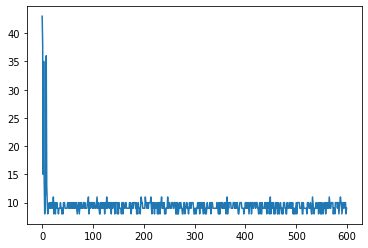

--------600---------
--------601---------
--------602---------
--------603---------
--------604---------
--------605---------
--------606---------
--------607---------
--------608---------
--------609---------
--------610---------
--------611---------
--------612---------
--------613---------
--------614---------
--------615---------
--------616---------
--------617---------
--------618---------
--------619---------
620번째 episode 학습 완료
[0. 1.]


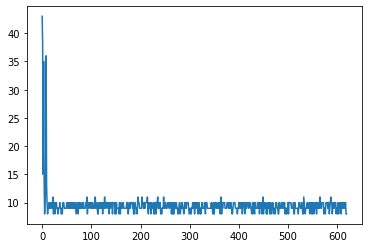

--------620---------
--------621---------
--------622---------
--------623---------
--------624---------
--------625---------
--------626---------
--------627---------
--------628---------
--------629---------
--------630---------
--------631---------
--------632---------
--------633---------
--------634---------
--------635---------
--------636---------
--------637---------
--------638---------
--------639---------
640번째 episode 학습 완료
[1. 0.]


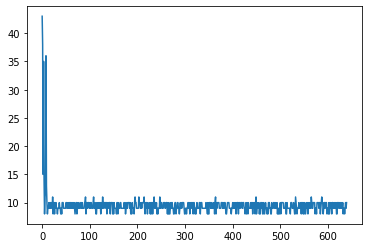

--------640---------
--------641---------
--------642---------
--------643---------
--------644---------
--------645---------
--------646---------
--------647---------
--------648---------
--------649---------
--------650---------
--------651---------
--------652---------
--------653---------
--------654---------
--------655---------
--------656---------
--------657---------
--------658---------
--------659---------
660번째 episode 학습 완료
[1. 0.]


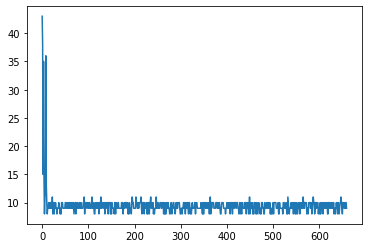

--------660---------
--------661---------
--------662---------
--------663---------
--------664---------
--------665---------
--------666---------
--------667---------
--------668---------
--------669---------
--------670---------
--------671---------
--------672---------
--------673---------
--------674---------
--------675---------
--------676---------
--------677---------
--------678---------
--------679---------
680번째 episode 학습 완료
[0. 1.]


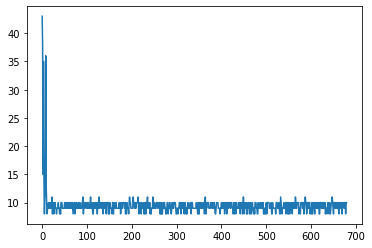

--------680---------
--------681---------
--------682---------
--------683---------
--------684---------
--------685---------
--------686---------
--------687---------
--------688---------
--------689---------
--------690---------
--------691---------
--------692---------
--------693---------
--------694---------
--------695---------
--------696---------
--------697---------
--------698---------
--------699---------
700번째 episode 학습 완료
[1. 0.]


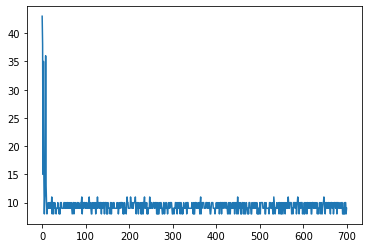

--------700---------
--------701---------
--------702---------
--------703---------
--------704---------
--------705---------
--------706---------
--------707---------
--------708---------
--------709---------
--------710---------
--------711---------
--------712---------
--------713---------
--------714---------
--------715---------
--------716---------
--------717---------
--------718---------
--------719---------
720번째 episode 학습 완료
[1. 0.]


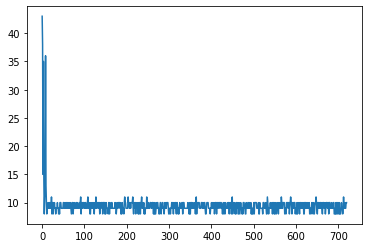

--------720---------
--------721---------
--------722---------
--------723---------
--------724---------
--------725---------
--------726---------
--------727---------
--------728---------
--------729---------
--------730---------
--------731---------
--------732---------
--------733---------
--------734---------
--------735---------
--------736---------
--------737---------
--------738---------
--------739---------
740번째 episode 학습 완료
[0. 1.]


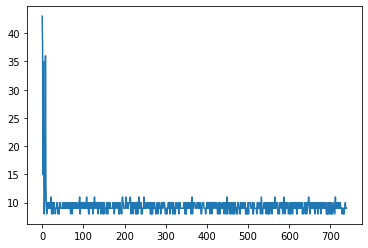

--------740---------
--------741---------
--------742---------
--------743---------
--------744---------
--------745---------
--------746---------
--------747---------
--------748---------
--------749---------
--------750---------
--------751---------
--------752---------
--------753---------
--------754---------
--------755---------
--------756---------
--------757---------
--------758---------
--------759---------
760번째 episode 학습 완료
[1. 0.]


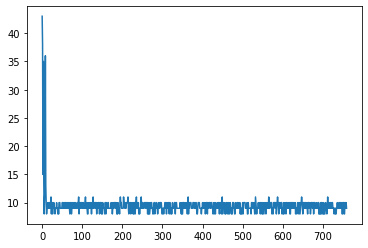

--------760---------
--------761---------
--------762---------
--------763---------
--------764---------
--------765---------
--------766---------
--------767---------
--------768---------
--------769---------
--------770---------
--------771---------
--------772---------
--------773---------
--------774---------
--------775---------
--------776---------
--------777---------
--------778---------
--------779---------
780번째 episode 학습 완료
[0. 1.]


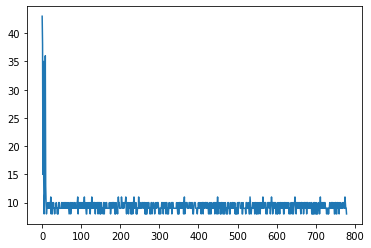

--------780---------
--------781---------
--------782---------
--------783---------
--------784---------
--------785---------
--------786---------
--------787---------
--------788---------
--------789---------
--------790---------
--------791---------
--------792---------
--------793---------
--------794---------
--------795---------
--------796---------
--------797---------
--------798---------
--------799---------
800번째 episode 학습 완료
[1. 0.]


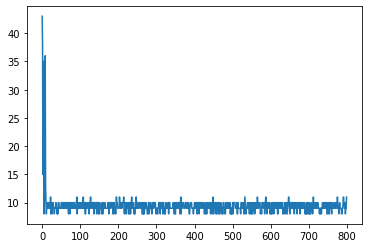

--------800---------
--------801---------
--------802---------
--------803---------
--------804---------
--------805---------
--------806---------
--------807---------
--------808---------
--------809---------
--------810---------
--------811---------
--------812---------
--------813---------
--------814---------
--------815---------
--------816---------
--------817---------
--------818---------
--------819---------
820번째 episode 학습 완료
[1. 0.]


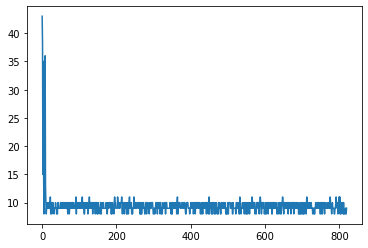

--------820---------
--------821---------
--------822---------
--------823---------
--------824---------
--------825---------
--------826---------
--------827---------
--------828---------
--------829---------
--------830---------
--------831---------
--------832---------
--------833---------
--------834---------
--------835---------
--------836---------
--------837---------
--------838---------
--------839---------
840번째 episode 학습 완료
[1. 0.]


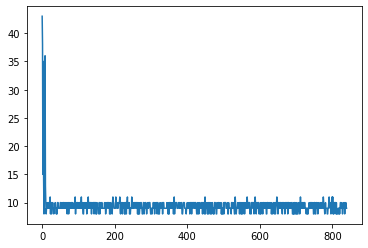

--------840---------
--------841---------
--------842---------
--------843---------
--------844---------
--------845---------
--------846---------
--------847---------
--------848---------
--------849---------
--------850---------
--------851---------
--------852---------
--------853---------
--------854---------
--------855---------
--------856---------
--------857---------
--------858---------
--------859---------
860번째 episode 학습 완료
[0. 1.]


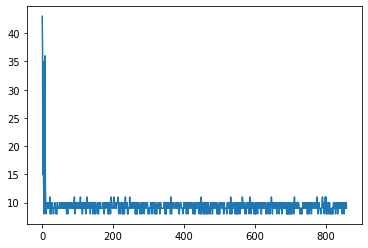

--------860---------
--------861---------
--------862---------
--------863---------
--------864---------
--------865---------
--------866---------
--------867---------
--------868---------
--------869---------
--------870---------
--------871---------
--------872---------
--------873---------
--------874---------
--------875---------
--------876---------
--------877---------
--------878---------
--------879---------
880번째 episode 학습 완료
[0. 1.]


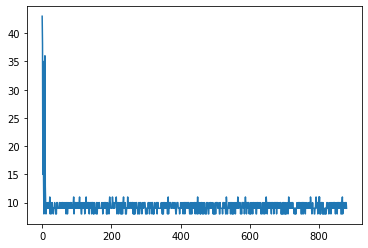

--------880---------
--------881---------
--------882---------
--------883---------
--------884---------
--------885---------
--------886---------
--------887---------
--------888---------
--------889---------
--------890---------
--------891---------
--------892---------
--------893---------
--------894---------
--------895---------
--------896---------
--------897---------
--------898---------
--------899---------
900번째 episode 학습 완료
[0. 1.]


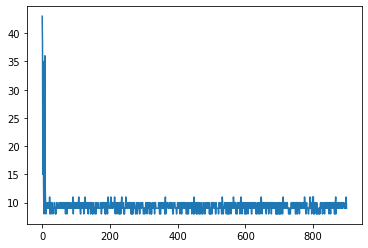

--------900---------
--------901---------
--------902---------
--------903---------
--------904---------
--------905---------
--------906---------
--------907---------
--------908---------
--------909---------
--------910---------
--------911---------
--------912---------
--------913---------
--------914---------
--------915---------
--------916---------
--------917---------
--------918---------
--------919---------
920번째 episode 학습 완료
[0. 1.]


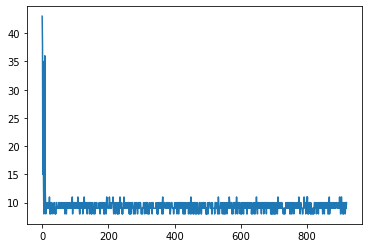

--------920---------
--------921---------
--------922---------
--------923---------
--------924---------
--------925---------
--------926---------
--------927---------
--------928---------
--------929---------
--------930---------
--------931---------
--------932---------
--------933---------
--------934---------
--------935---------
--------936---------
--------937---------
--------938---------
--------939---------
940번째 episode 학습 완료
[1. 0.]


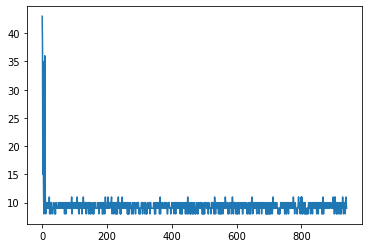

--------940---------
--------941---------
--------942---------
--------943---------
--------944---------
--------945---------
--------946---------
--------947---------
--------948---------
--------949---------
--------950---------
--------951---------
--------952---------
--------953---------
--------954---------
--------955---------
--------956---------
--------957---------
--------958---------
--------959---------
960번째 episode 학습 완료
[0. 1.]


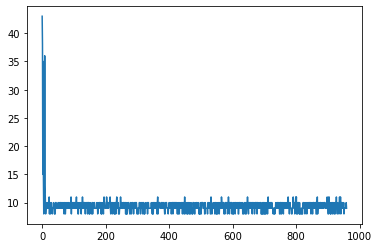

--------960---------
--------961---------
--------962---------
--------963---------
--------964---------
--------965---------
--------966---------
--------967---------
--------968---------
--------969---------
--------970---------
--------971---------
--------972---------
--------973---------
--------974---------
--------975---------
--------976---------
--------977---------
--------978---------
--------979---------
980번째 episode 학습 완료
[1. 0.]


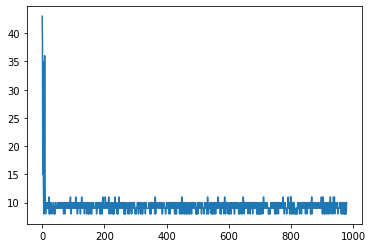

--------980---------
--------981---------
--------982---------
--------983---------
--------984---------
--------985---------
--------986---------
--------987---------
--------988---------
--------989---------
--------990---------
--------991---------
--------992---------
--------993---------
--------994---------
--------995---------
--------996---------
--------997---------
--------998---------
--------999---------
1000번째 episode 학습 완료
[1. 0.]


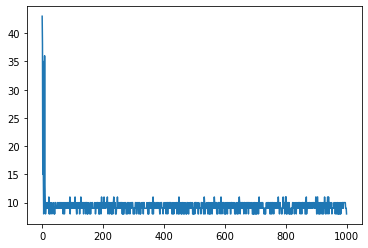

--------1000---------
--------1001---------
--------1002---------
--------1003---------
--------1004---------
--------1005---------
--------1006---------
--------1007---------
--------1008---------
--------1009---------
--------1010---------
--------1011---------
--------1012---------
--------1013---------
--------1014---------
--------1015---------
--------1016---------
--------1017---------
--------1018---------
--------1019---------
1020번째 episode 학습 완료
[0. 1.]


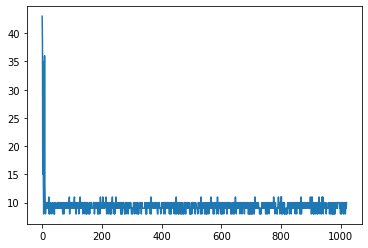

--------1020---------
--------1021---------
--------1022---------
--------1023---------
--------1024---------
--------1025---------
--------1026---------
--------1027---------
--------1028---------
--------1029---------
--------1030---------
--------1031---------
--------1032---------
--------1033---------
--------1034---------
--------1035---------
--------1036---------
--------1037---------
--------1038---------
--------1039---------
1040번째 episode 학습 완료
[0. 1.]


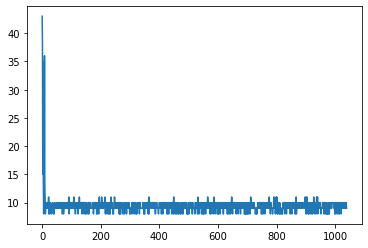

--------1040---------
--------1041---------
--------1042---------
--------1043---------
--------1044---------
--------1045---------
--------1046---------
--------1047---------
--------1048---------
--------1049---------
--------1050---------
--------1051---------
--------1052---------
--------1053---------
--------1054---------
--------1055---------
--------1056---------
--------1057---------
--------1058---------
--------1059---------
1060번째 episode 학습 완료
[0. 1.]


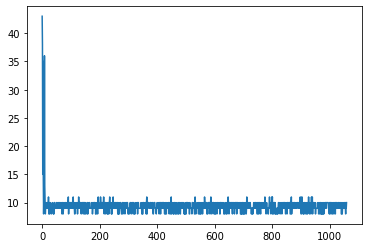

--------1060---------
--------1061---------
--------1062---------
--------1063---------
--------1064---------
--------1065---------
--------1066---------
--------1067---------
--------1068---------
--------1069---------
--------1070---------
--------1071---------
--------1072---------
--------1073---------
--------1074---------
--------1075---------
--------1076---------
--------1077---------
--------1078---------
--------1079---------
1080번째 episode 학습 완료
[1. 0.]


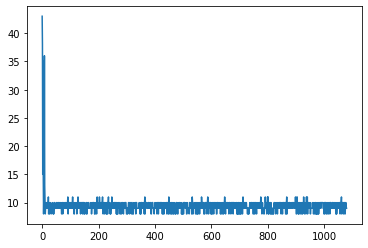

--------1080---------
--------1081---------
--------1082---------
--------1083---------
--------1084---------
--------1085---------
--------1086---------
--------1087---------
--------1088---------
--------1089---------
--------1090---------
--------1091---------
--------1092---------
--------1093---------
--------1094---------
--------1095---------
--------1096---------
--------1097---------
--------1098---------
--------1099---------
1100번째 episode 학습 완료
[0. 1.]


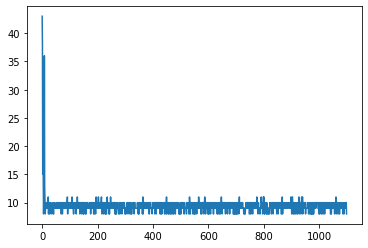

--------1100---------
--------1101---------
--------1102---------
--------1103---------
--------1104---------
--------1105---------
--------1106---------
--------1107---------
--------1108---------
--------1109---------
--------1110---------
--------1111---------
--------1112---------
--------1113---------
--------1114---------
--------1115---------
--------1116---------
--------1117---------
--------1118---------
--------1119---------
1120번째 episode 학습 완료
[0. 1.]


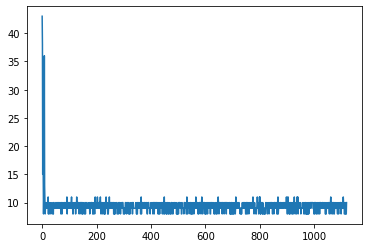

--------1120---------
--------1121---------
--------1122---------
--------1123---------
--------1124---------
--------1125---------
--------1126---------
--------1127---------
--------1128---------
--------1129---------
--------1130---------
--------1131---------
--------1132---------
--------1133---------
--------1134---------
--------1135---------
--------1136---------
--------1137---------
--------1138---------
--------1139---------
1140번째 episode 학습 완료
[1. 0.]


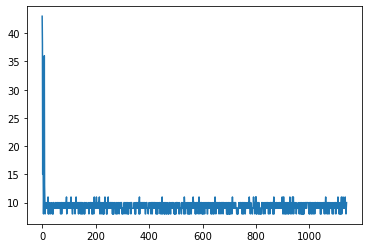

--------1140---------
--------1141---------
--------1142---------
--------1143---------
--------1144---------
--------1145---------
--------1146---------
--------1147---------
--------1148---------
--------1149---------
--------1150---------
--------1151---------
--------1152---------
--------1153---------
--------1154---------
--------1155---------
--------1156---------
--------1157---------
--------1158---------
--------1159---------
1160번째 episode 학습 완료
[0. 1.]


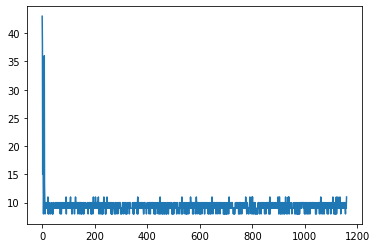

--------1160---------
--------1161---------
--------1162---------
--------1163---------
--------1164---------
--------1165---------
--------1166---------
--------1167---------
--------1168---------
--------1169---------
--------1170---------
--------1171---------
--------1172---------
--------1173---------
--------1174---------
--------1175---------
--------1176---------
--------1177---------
--------1178---------
--------1179---------
1180번째 episode 학습 완료
[1. 0.]


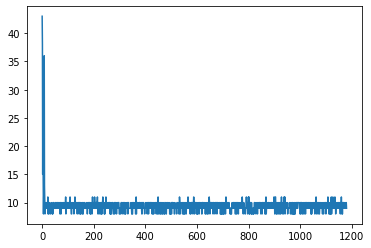

--------1180---------
--------1181---------
--------1182---------
--------1183---------
--------1184---------
--------1185---------
--------1186---------
--------1187---------
--------1188---------
--------1189---------
--------1190---------
--------1191---------
--------1192---------
--------1193---------
--------1194---------
--------1195---------
--------1196---------
--------1197---------
--------1198---------
--------1199---------
1200번째 episode 학습 완료
[1. 0.]


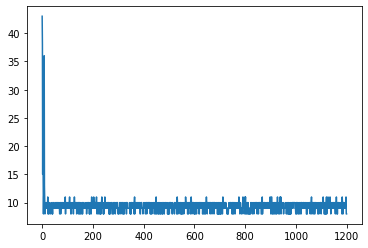

--------1200---------
--------1201---------
--------1202---------
--------1203---------
--------1204---------
--------1205---------
--------1206---------
--------1207---------
--------1208---------
--------1209---------
--------1210---------
--------1211---------
--------1212---------
--------1213---------
--------1214---------
--------1215---------
--------1216---------
--------1217---------
--------1218---------
--------1219---------
1220번째 episode 학습 완료
[1. 0.]


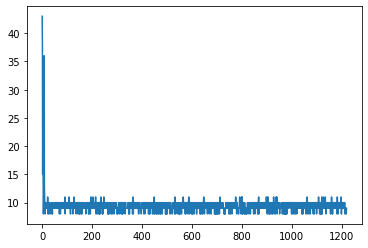

--------1220---------
--------1221---------
--------1222---------
--------1223---------
--------1224---------
--------1225---------
--------1226---------
--------1227---------
--------1228---------
--------1229---------
--------1230---------
--------1231---------
--------1232---------
--------1233---------
--------1234---------
--------1235---------
--------1236---------
--------1237---------
--------1238---------
--------1239---------
1240번째 episode 학습 완료
[1. 0.]


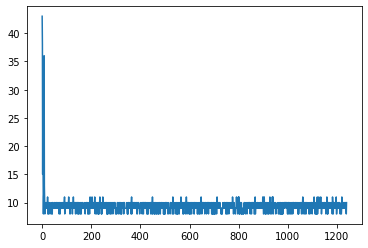

--------1240---------
--------1241---------
--------1242---------
--------1243---------
--------1244---------
--------1245---------
--------1246---------
--------1247---------
--------1248---------
--------1249---------
--------1250---------
--------1251---------
--------1252---------
--------1253---------
--------1254---------
--------1255---------
--------1256---------
--------1257---------
--------1258---------
--------1259---------
1260번째 episode 학습 완료
[0. 1.]


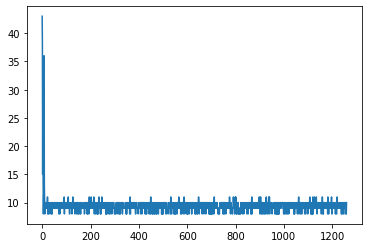

--------1260---------
--------1261---------
--------1262---------
--------1263---------
--------1264---------
--------1265---------
--------1266---------
--------1267---------
--------1268---------
--------1269---------
--------1270---------
--------1271---------
--------1272---------
--------1273---------
--------1274---------
--------1275---------
--------1276---------
--------1277---------
--------1278---------
--------1279---------
1280번째 episode 학습 완료
[1. 0.]


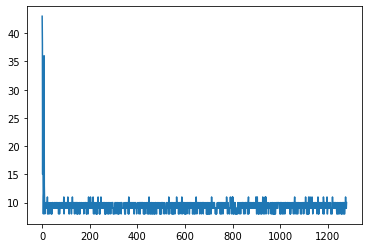

--------1280---------
--------1281---------
--------1282---------
--------1283---------
--------1284---------
--------1285---------
--------1286---------
--------1287---------
--------1288---------
--------1289---------
--------1290---------
--------1291---------
--------1292---------
--------1293---------
--------1294---------
--------1295---------
--------1296---------
--------1297---------
--------1298---------
--------1299---------
1300번째 episode 학습 완료
[1. 0.]


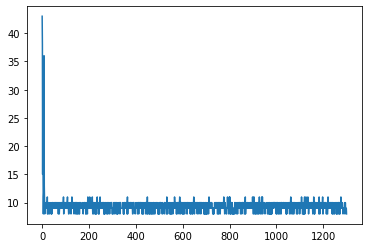

--------1300---------
--------1301---------
--------1302---------
--------1303---------
--------1304---------
--------1305---------
--------1306---------
--------1307---------
--------1308---------
--------1309---------
--------1310---------
--------1311---------
--------1312---------
--------1313---------
--------1314---------
--------1315---------
--------1316---------
--------1317---------
--------1318---------
--------1319---------
1320번째 episode 학습 완료
[1. 0.]


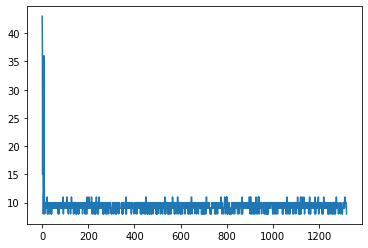

--------1320---------
--------1321---------
--------1322---------
--------1323---------
--------1324---------
--------1325---------
--------1326---------
--------1327---------
--------1328---------
--------1329---------
--------1330---------
--------1331---------
--------1332---------
--------1333---------
--------1334---------
--------1335---------
--------1336---------
--------1337---------
--------1338---------
--------1339---------
1340번째 episode 학습 완료
[0. 1.]


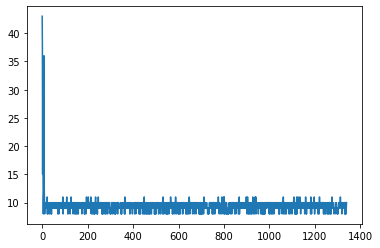

--------1340---------
--------1341---------
--------1342---------
--------1343---------
--------1344---------
--------1345---------
--------1346---------
--------1347---------
--------1348---------
--------1349---------
--------1350---------
--------1351---------
--------1352---------
--------1353---------
--------1354---------
--------1355---------
--------1356---------
--------1357---------
--------1358---------
--------1359---------
1360번째 episode 학습 완료
[0. 1.]


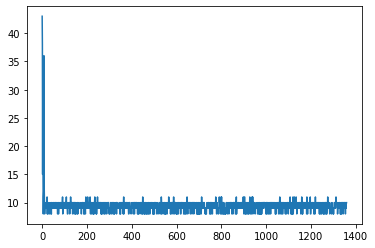

--------1360---------
--------1361---------
--------1362---------
--------1363---------
--------1364---------
--------1365---------
--------1366---------
--------1367---------
--------1368---------
--------1369---------
--------1370---------
--------1371---------
--------1372---------
--------1373---------
--------1374---------
--------1375---------
--------1376---------
--------1377---------
--------1378---------
--------1379---------
1380번째 episode 학습 완료
[1. 0.]


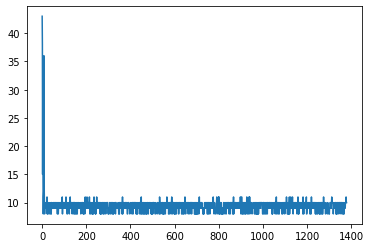

--------1380---------
--------1381---------
--------1382---------
--------1383---------


In [ ]:
n_episode = 2000
gamma = 0.99
rewards_cum = []

for episode in range(n_episode):
    print('--------{}---------'.format(episode))
    r_c = 0
    #### 에피소드 생성
    state_history = []
    action_history = []
    reward_history = []

    for i in range(1):
        env = wrap_env(gym.make("CartPole-v1"))
        s0 = env.reset()
        done = False

        time_step = 0
        while True :
            time_step = time_step + 1

            s0 = s0.reshape([1, -1])
            policy = policy_network.predict(s0).reshape(-1)
            a0 = np.random.choice(env.action_space.n, p = policy)
            s1, r1, done, _ = env.step(a0)
            
            a0 = np.eye(env.action_space.n)[a0].reshape([1,-1])
            
            state_history.append(s0)
            action_history.append(a0)
            reward_history.append(r1)

            # if time_step % 100 == 0 :
            #     print(" TimeStep : {} 진행중".format(time_step))

            if done == True :
                env.close()
                # show_video()
                break
            s0 = s1
    rewards_cum.append(sum(reward_history))
    #### 학습
    memory.append((state_history, action_history, reward_history))
    for history in memory :
        state_history = history[0]
        action_history = history[1]
        reward_history = history[2]

        returns = []
        Gt = 0
        for r in reward_history[::-1] : # 거꾸로 뽑는다.
            Gt = r + gamma*Gt
            returns.insert(0,  Gt) # append를 0번 인덱스부터 하는 것!
        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.reshape([-1,1])
        returns.shape

        state = np.vstack(state_history)
        action_dummy = np.vstack(action_history)
        G_target = action_dummy*returns
        policy_network.fit(state, G_target, verbose=0, epochs=1, batch_size=100000)

    if (episode+1) % 20 == 0 :
        print("{}번째 episode 학습 완료".format(episode+1))
        print(policy)
        show_video()
        plt.plot(rewards_cum)
        plt.show()
